# Royal Flush

An analysis of 1000 pairs of Poker hands to determine the winner. 

Author: Mark Richards

Email: mark.thomas.richards@outlook.com

## Overview

This is my attempt to solve [Project Euler Problem 54](https://projecteuler.net/problem=54) using data analysis. 

If you are not aware, Project Euler is an online archive of 800+ graded mathematically-oriented programming challenges, which are a good place to start when learning to solve reasonably complex problems.

Most data analysis case studies involve just manipulating data (grouping, aggregating, etc) but I wanted to try something a little more complex and as you will see below this is not a simple problem :)

## The Problem

We are given a 1000 line text file where each line represents a pair of 5-card poker hands. 

```
8C TS KC 9H 4S 7D 2S 5D 3S AC
5C AD 5D AC 9C 7C 5H 8D TD KS
3H 7H 6S KC JS QH TD JC 2D 8S
...
```

Each card is encoded as rank+suit: "8C" = Eight of clubs, etc.

The first five cards are player 1's hand and the second five are player 2's hand.

The goal is for us to determine, for each pair of hands, who was the winner, applying the standard ranking of poker hands, so that we can find out how many hands player 1 won.

Poker hand evaluation is quite complex. In order from lowest rank to highest we have:

- High Card: Highest value card.
- One Pair: Two cards of the same value.
- Two Pairs: Two different pairs.
- Three of a Kind: Three cards of the same value.
- Straight: All cards are consecutive values.
- Flush: All cards of the same suit.
- Full House: Three of a kind and a pair.
- Four of a Kind: Four cards of the same value.
- Straight Flush: All cards are consecutive values of same suit.
- Royal Flush: Ten, Jack, Queen, King, Ace, in same suit.

So if player 1 has a Full House and player 2 has Three of a Kind, player 1 wins. But if both players have, say, Three of a Kind, then we have to apply additional rules to determine the winner (for Three of a Kind, the player with the highest card in the Three of a Kind). 

__You might reasonably ask what this has to do with data analysis:__ we are (probably) never going to be asked to analyse poker hands in real life. But we can imagine some analysis like this being needed in a real business task: for example, we could be analysing sales of a service to customers where the customer can choose different "modules" to be part of the service and perhaps the "value" for the company of selling different combinations of modules is different from simply the retail price - maybe some combinations correlate with longer customer retention, or with increased tech support revenue down the line, etc. So the company might present us with a ranked list of how to value sales of different combinations and this is not so different from a ranking of poker hands. 


## Loading the Data

Lets first read in the text file, adding some column names so we know what we are looking at.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_hands = pd.read_csv(
    "poker.txt", 
    sep=" ", 
    header=None, 
    names=[
        # player 1's hand
        "p1_1", "p1_2", "p1_3", "p1_4", "p1_5", 
        # player 2's hand
        "p2_1", "p2_2", "p2_3", "p2_4", "p2_5"]
)

df_hands

,p1_1,p1_2,p1_3,p1_4,p1_5,p2_1,p2_2,p2_3,p2_4,p2_5
0,8C,TS,KC,9H,4S,7D,2S,5D,3S,AC
1,5C,AD,5D,AC,9C,7C,5H,8D,TD,KS
2,3H,7H,6S,KC,JS,QH,TD,JC,2D,8S
3,TH,8H,5C,QS,TC,9H,4D,JC,KS,JS
4,7C,5H,KC,QH,JD,AS,KH,4C,AD,4S
...,...,...,...,...,...,...,...,...,...,...
995,3S,AD,9H,JC,6D,JD,AS,KH,6S,JH
996,AD,3D,TS,KS,7H,JH,2D,JS,QD,AC
997,9C,JD,7C,6D,TC,6H,6C,JC,3D,3S
998,QC,KC,3S,JC,KD,2C,8D,AH,QS,TS


## Cleaning

The data should already be clean since it is designed for this problem, but lets sense check it anyway.

Lets make sure we have no missing values.

In [3]:
df_hands.isna().sum()

p1_1    0
p1_2    0
p1_3    0
p1_4    0
p1_5    0
p2_1    0
p2_2    0
p2_3    0
p2_4    0
p2_5    0
dtype: int64

And make sure each field is only 2 characters.

In [4]:
df_hands.applymap(len).value_counts()

p1_1  p1_2  p1_3  p1_4  p1_5  p2_1  p2_2  p2_3  p2_4  p2_5
2     2     2     2     2     2     2     2     2     2       1000
dtype: int64

Finally, although its conceivable that we could get duplicated hands by chance, lets check for duplicated rows anyway.

In [5]:
df_hands.duplicated().sum()

0

## Analysis

Since we wil be adding more columns as we process the data, it makes sense to split the two players hands into two dataframes so we can see them better. 

We need to make sure that for each dataframe we add the current index to the table as a column, as we may end up manipulating the index later and we need to make sure we can still match up the players hands.

In [6]:
df_p1 = (df_hands
         .iloc[:, 0:5]
         .reset_index()
         .rename(columns={"index": "hand"})
        )

df_p2 = (df_hands
         .iloc[:, 5:]
         .reset_index()
         .rename(columns={"index": "hand"})
        )

In [7]:
df_p1

,hand,p1_1,p1_2,p1_3,p1_4,p1_5
0,0,8C,TS,KC,9H,4S
1,1,5C,AD,5D,AC,9C
2,2,3H,7H,6S,KC,JS
3,3,TH,8H,5C,QS,TC
4,4,7C,5H,KC,QH,JD
...,...,...,...,...,...,...
995,995,3S,AD,9H,JC,6D
996,996,AD,3D,TS,KS,7H
997,997,9C,JD,7C,6D,TC
998,998,QC,KC,3S,JC,KD


In [8]:
df_p2

,hand,p2_1,p2_2,p2_3,p2_4,p2_5
0,0,7D,2S,5D,3S,AC
1,1,7C,5H,8D,TD,KS
2,2,QH,TD,JC,2D,8S
3,3,9H,4D,JC,KS,JS
4,4,AS,KH,4C,AD,4S
...,...,...,...,...,...,...
995,995,JD,AS,KH,6S,JH
996,996,JH,2D,JS,QD,AC
997,997,6H,6C,JC,3D,3S
998,998,2C,8D,AH,QS,TS


__So, how are we going to solve this problem?__

Lets make a __plan__.

1. For each of the __poker hand ranking types__ (Three of a Kind, Straight, etc) we determine if a hand matches that type, then add a column to the dataframe for that type and populate it with True or False. For some of the hand rankings we need to know additional data (like for Three of A Kind, we need to know whether its three 9s or three 5s, etc) so for those cases we add an additional column to record that. 
2. Then we determine the players __best hand ranking__ (we can imagine that they might have Three of A Kind plus a Pair, so we need to know the _best_ of the different hand rankings they have). This can be populated in another column. 
3. For each hand, we compare whether player 1 or player 2 has the best hand, determine a __winner__, and populate a dataframe with which player won each hand.
4. Finally we can count __how many hands player 1 won__.

We need a simple way to parse each card string so that we know the suit and rank and also a simple way to get the ranks and suits of all the cards in a players hand. 

We'll convert the rank into integers so that they can easily be compared. We need to remember that 10 is represented as "T" and we also have to handle "J", "Q", "K", "A", which we will value as 11, 12, 13, 14 (aces are high in poker).

In [9]:
# Card Ranks
# ==========

def card_rank(card):
    """Returns the rank of a card as an integer."""
    
    card_num = card[0]
    
    switch = {
        "T": 10,
        "J": 11,
        "Q": 12,
        "K": 13,
        "A": 14
        }
    
    # if rank is T, J, Q, K, A return the matching integer
    if card_num in switch.keys():
        return switch[card_num]
    else:
        # convert number string to integer
        return int(card_num)
    
def get_hand_ranks(r):
    """
    Takes a row from the player dataframe and returns a 
    list of hand ranks.
    """
    return (r
            .iloc[1:6]
            .map(card_rank)
            .sort_values()
            .tolist()
           )
    
# Card Suits
# ==========
    
def card_suit(card):
    """Returns the suit of a card."""
    return card[1]

def get_hand_suits(r):
    """
    Takes a row from the player dataframe and returns a 
    list of hand suits.
    """
    return (r
            .iloc[1:6]
            .map(card_suit)
            .sort_values()
            .tolist()
           )

In [10]:
# testing
print(card_rank("TC"))
print(card_rank("6D"))
print(get_hand_ranks(df_p1.iloc[0, :]))

10
6
[4, 8, 9, 10, 13]


In [11]:
# testing
print(card_suit("TC"))
print(card_suit("6D"))
print(get_hand_suits(df_p1.iloc[0, :]))

C
D
['C', 'C', 'H', 'S', 'S']


#### Poker Hand Ranking Types

We need to go through the list of poker hand ranking types and for each come up with a function which takes a players dataframe of hands and returns the same dataframe with a boolean column added for whether each hand matches that type and also a column for the additional data we need to record.

Then if we apply all the functions in sequence on the players hand dataframe we will end up with an expanded dataframe which contains all the information to needed meet point (1) of our plan.

__Note:__ I have deliberately not refactored out some of the helper functions used below so that you can see exactly what is happening in each function just by looking at that function.

In [12]:
# High Card
# =========
#
# Every players hand will have a highest card, so we do not need to record whether
# this ranking type matches, we just need to record the highest card.

def high_card(df):
    """
    Takes a df of player hands and appends a new column containing
    the highest rank in each hand.
    """
    
    def max_of_hand(r):
        """Returns the highest rank in a hand."""
        return max(
            *get_hand_ranks(r)
        )
    
    df["high_card"] = df.apply(max_of_hand, axis=1)
    
    return df

In [13]:
# output
high_card(df_p1)

,hand,p1_1,p1_2,p1_3,p1_4,p1_5,high_card
0,0,8C,TS,KC,9H,4S,13
1,1,5C,AD,5D,AC,9C,14
2,2,3H,7H,6S,KC,JS,13
3,3,TH,8H,5C,QS,TC,12
4,4,7C,5H,KC,QH,JD,13
...,...,...,...,...,...,...,...
995,995,3S,AD,9H,JC,6D,14
996,996,AD,3D,TS,KS,7H,14
997,997,9C,JD,7C,6D,TC,11
998,998,QC,KC,3S,JC,KD,13


In [14]:
# One Pair
# ========
#
# Here we just need to determine if there is one duplicate rank
# in the hand and what rank is duplicated.

def one_pair(df):
    """
    Takes a df of player hands and appends a new column containing
    a boolean for if the hand contains a single pair and a column
    recording the rank of the pair.
    """          

    def find_pairs(r):
        """Find pairs in a hand."""
        # get the rank of each card in the hand
        cards = get_hand_ranks(r)

        # count the number of occurences of each rank
        rank_counts = {}
        for card in cards:
            if card in rank_counts.keys():
                rank_counts[card] = rank_counts[card] + 1
            else:
                rank_counts[card] = 1

        # find the number of ranks occuring exactly twice
        return [val for val in rank_counts.keys() if rank_counts[val] == 2]

    def pair_check(r):
        """
        Checks if a *single* pair is present in a hand and if so returns True.
        """
        pairs = find_pairs(r)
        
        # if there is only one pair, return True
        return len(pairs) == 1
    
    
    def pair_rank(r):
        """
        Checks if a *single* pair is present in a hand and if so returns its
        rank else 0.
        """
        pairs = find_pairs(r)
        
        # if there is only one pair, return True
        if len(pairs) == 1:
            return pairs[0]
        else:
            return 0
    
    # apply the functions to the dataframe
    df["one_pair"] = df.apply(pair_check, axis=1)
    df["one_pair_rank"] = df.apply(pair_rank, axis=1)
    
    return df

In [15]:
# output
one_pair(df_p1)

,hand,p1_1,p1_2,p1_3,p1_4,p1_5,high_card,one_pair,one_pair_rank
0,0,8C,TS,KC,9H,4S,13,False,0
1,1,5C,AD,5D,AC,9C,14,False,0
2,2,3H,7H,6S,KC,JS,13,False,0
3,3,TH,8H,5C,QS,TC,12,True,10
4,4,7C,5H,KC,QH,JD,13,False,0
...,...,...,...,...,...,...,...,...,...
995,995,3S,AD,9H,JC,6D,14,False,0
996,996,AD,3D,TS,KS,7H,14,False,0
997,997,9C,JD,7C,6D,TC,11,False,0
998,998,QC,KC,3S,JC,KD,13,True,13


In [16]:
# Two Pairs
# =========
#
# Here we need to determine if there are two separate pairs in the hand,
# add a boolean column, and add two more columns for the ranks of each pair.
# We can use much the same approach as for One Pair.


def two_pair(df):
    """
    Takes a df of player hands and appends a new column containing a 
    boolean for if two pairs exist, plus two columns for the ranks of
    each pair.
    """
    
    def find_two_pairs(r):
        """Find two pairs in a hand."""
        
        # get the rank of each card in the hand
        cards = get_hand_ranks(r)

        # count the number of occurences of each rank
        rank_counts = {}
        for card in cards:
            if card in rank_counts.keys():
                rank_counts[card] = rank_counts[card] + 1
            else:
                rank_counts[card] = 1
                
        # find the number of ranks occuring exactly twice
        return [val for val in rank_counts.keys() if rank_counts[val] == 2]
    
    def two_pair_check(r):
        """
        Checks if a *two* pairs is present in a hand and if so returns True.
        """
        pairs = find_two_pairs(r)
        
        # if there are two pairs, return True
        return len(pairs) == 2
    
    def two_pair_rank_1(r):
        """
        Checks if a *two* pairs is present in a hand and if so returns the
        highest ranked pair value.
        """
        pairs = find_two_pairs(r)
        
        # if there are two pairs return the max pair
        if len(pairs) == 2:
            return max(pairs)
        else:
            return 0
        
    def two_pair_rank_2(r):
        """
        Checks if a *two* pairs is present in a hand and if so returns the
        lowest ranked pair value.
        """
        pairs = find_two_pairs(r)

        # if there are two pairs return the min pair
        if len(pairs) == 2:
            return min(pairs)
        else:
            return 0
        
    # apply the functions to the dataframe
    df["two_pair"] = df.apply(two_pair_check, axis=1)
    df["two_pair_rank_1"] = df.apply(two_pair_rank_1, axis=1)
    df["two_pair_rank_2"] = df.apply(two_pair_rank_2, axis=1)
    
    
    return df
    

In [17]:
# output
(two_pair(df_p1)
 .query("two_pair == True")
 .head()
)

,hand,p1_1,p1_2,p1_3,p1_4,p1_5,high_card,one_pair,one_pair_rank,two_pair,two_pair_rank_1,two_pair_rank_2
1,1,5C,AD,5D,AC,9C,14,False,0,True,14,5
17,17,6S,8D,4C,8S,6C,8,False,0,True,8,6
43,43,2H,2C,6H,TH,TC,10,False,0,True,10,2
75,75,JC,6H,6S,JS,4H,11,False,0,True,11,6
111,111,5S,9C,KH,KD,9H,13,False,0,True,13,9


In [18]:
# Three of a Kind
# ===============
#
# Again we can use the same approach as above.
# There can only be one three of a kind in a hand,
# so we only need to record one additional rank.

def three_of_a_kind(df):
    """
    Takes a df of player hands and appends a new column containing a 
    boolean for if three of a kind exists, plus a column for the rank.
    """
    
    def find_three_of_a_kind(r):
        """Find three of a kind in a hand."""
        
        # get the rank of each card in the hand
        cards = get_hand_ranks(r)

        # count the number of occurences of each rank
        rank_counts = {}
        for card in cards:
            if card in rank_counts.keys():
                rank_counts[card] = rank_counts[card] + 1
            else:
                rank_counts[card] = 1
                
        # find the number of ranks occuring three times
        return [val for val in rank_counts.keys() if rank_counts[val] == 3]
    
    def three_of_a_kind_check(r):
        """
        Checks if three of a kind is present in a hand and if so returns True.
        """
        threes = find_three_of_a_kind(r)
        
        # if there is three of a kind return True
        return len(threes) == 1

    def three_of_a_kind_rank(r):
        """
        Checks if a three of a kind is present in a hand and if so returns the
        rank.
        """
        threes = find_three_of_a_kind(r)
        
        # if there is three of a kind return its rank
        if len(threes) == 1:
            return threes[0]
        else:
            return 0
        
    # apply the functions to the dataframe
    df["three_of_a_kind"] = df.apply(three_of_a_kind_check, axis=1)
    df["three_of_a_kind_rank"] = df.apply(three_of_a_kind_rank, axis=1)
    
    return df
    

In [19]:
# output
(three_of_a_kind(df_p1)
 .query("three_of_a_kind == True")
 .head()
)

,hand,p1_1,p1_2,p1_3,p1_4,p1_5,high_card,one_pair,one_pair_rank,two_pair,two_pair_rank_1,two_pair_rank_2,three_of_a_kind,three_of_a_kind_rank
52,52,AD,3C,3D,KS,3S,14,False,0,False,0,0,True,3
60,60,3D,AD,3C,3S,4C,14,False,0,False,0,0,True,3
189,189,QD,9H,5S,QS,QC,12,False,0,False,0,0,True,12
203,203,JD,JS,JC,TH,2D,11,False,0,False,0,0,True,11
472,472,6H,4H,6C,7H,6S,7,False,0,False,0,0,True,6


In [20]:
# Straight
# ========
# 
# For this we need to check if all the cards in a hand are consecutive values
# and if so what the highest card is.
# There are only a small number of possible straights, so we can just define a
# list of these and check for membership.

def straight(df):
    """
    Takes a df of player hands and appends a new column containing a 
    boolean for if a straight exists, plus a column for the rank.
    """
    
    possible_straights = [
        [2, 3, 4, 5, 6],
        [3, 4, 5, 6, 7],
        [4, 5, 6, 7, 8],
        [5, 6, 7, 8, 9],
        [6, 7, 8, 9, 10],
        [7, 8, 9, 10, 11],
        [8, 9, 10, 11, 12],
        [9, 10, 11, 12, 13],
        [10, 11, 12, 13, 14]
    ]
    
    def straight_check(r):
        """Returns true if straight in hand."""
        
        hand = get_hand_ranks(r)
        
        return hand in possible_straights
    
    def straight_rank(r):
        """Returns the highest rank of a straight in a hand."""
        
        hand = get_hand_ranks(r)
        
        if hand in possible_straights:
            return max(hand)
        else:
            return 0
        
    # apply the functions to the dataframe
    df["straight"] = df.apply(straight_check, axis=1)
    df["straight_rank"] = df.apply(straight_rank, axis=1)
    
    return df

In [21]:
# output
(straight(df_p1)
 .query("straight == True")
 .head()
)

,hand,p1_1,p1_2,p1_3,p1_4,p1_5,high_card,one_pair,one_pair_rank,two_pair,two_pair_rank_1,two_pair_rank_2,three_of_a_kind,three_of_a_kind_rank,straight,straight_rank
6,6,6H,4H,5C,3H,2H,6,False,0,False,0,0,False,0,True,6
241,241,TS,8H,9S,6S,7S,10,False,0,False,0,0,False,0,True,10
575,575,3C,2D,4C,5S,6C,6,False,0,False,0,0,False,0,True,6
633,633,KS,JC,QD,TH,9S,13,False,0,False,0,0,False,0,True,13


In [22]:
# Flush
# =====
#
# In a flush, all cards are of the same suit.

def flush(df):
    """
    Takes a df of player hands and appends a new column containing a 
    boolean for if a flush exists, plus a column for the highest rank.
    """  
    
    def flush_check(r):
        """Returns True if flush exists."""
        
        hand = get_hand_suits(r)
        
        # if all the suits are the same return True
        return len(set(hand)) == 1
    
    def flush_rank(r):
        """Return the highest card in a flush."""
        
        hand = get_hand_suits(r)
        
        if len(set(hand)) == 1:
            return max(get_hand_ranks(r))
        else:
            return 0
        
    # apply the functions to the dataframe
    df["flush"] = df.apply(flush_check, axis=1)
    df["flush_rank"] = df.apply(flush_rank, axis=1)
    
    return df 
    

In [23]:
# output
(flush(df_p1)
 .query("flush == True")
 .head()
)

,hand,p1_1,p1_2,p1_3,p1_4,p1_5,high_card,one_pair,one_pair_rank,two_pair,two_pair_rank_1,two_pair_rank_2,three_of_a_kind,three_of_a_kind_rank,straight,straight_rank,flush,flush_rank
423,423,7C,4C,9C,2C,5C,9,False,0,False,0,0,False,0,False,0,True,9


In [24]:
# Full House
# ==========
# 
# A full house is three of a kind and a pair.

def full_house(df):
    """
    Takes a df of player hands and appends a new column containing a 
    boolean for if a full house exists, plus a column for the rank of 
    the three of a kind, and a column for the rank of the pair.
    """
    
    def find_rank_counts(r):
        """Returns the count of ranks in a hand."""
        
        cards = get_hand_ranks(r)
        
        # count the number of occurences of each rank
        rank_counts = {}
        for card in cards:
            if card in rank_counts.keys():
                rank_counts[card] = rank_counts[card] + 1
            else:
                rank_counts[card] = 1
        
        return rank_counts
    
    def full_house_check(r):
        """Returns True if a full house exists."""
        
        rank_counts = find_rank_counts(r)
        
        # if there are 2 of one rank and 3 of another return True
        return sorted(list(rank_counts.values())) == [2, 3]
    
    def full_house_three_of_a_kind_rank(r):
        """
        Returns the rank of the three of a kind if a
        full house exists.
        """
        
        rank_counts = find_rank_counts(r)
        
        # if a full house exists, return the rank of the 
        # three of a kind
        if sorted(list(rank_counts.values())) == [2, 3]:
            for rank, count in rank_counts.items():
                if count == 3:
                    return rank
        else:
            return 0
        
    def full_house_pair_rank(r):
        """
        Returns the rank of the pair if a
        full house exists.
        """
        
        rank_counts = find_rank_counts(r)
        
        # if a full house exists, return the rank of the pair
        if sorted(list(rank_counts.values())) == [2, 3]:
            for rank, count in rank_counts.items():
                if count == 2:
                    return rank
        else:
            return 0

    # apply the functions to the dataframe
    df["full_house"] = df.apply(full_house_check, axis=1)
    df["full_house_three_of_a_kind_rank"] = df.apply(full_house_three_of_a_kind_rank, axis=1)
    df["full_house_pair_rank"] = df.apply(full_house_pair_rank, axis=1)
    
    return df 

In [25]:
# output
(full_house(df_p2)
 .query("full_house == True")
 .head()
)

,hand,p2_1,p2_2,p2_3,p2_4,p2_5,full_house,full_house_three_of_a_kind_rank,full_house_pair_rank
256,256,6H,6S,6C,KS,KH,True,6,13
544,544,TH,TD,TC,KD,KS,True,10,13


In [26]:
# Four of a Kind
# ==============
#
# This is just four cards of the same rank, so we can use the same
# approach as for three of a kind.

def four_of_a_kind(df):
    """
    Takes a df of player hands and appends a new column containing a 
    boolean for if four of a kind exists, plus a column for the rank of 
    the four of a kind.
    """
    
    def find_four_of_a_kind(r):
        """Find four of a kind in a hand."""
        
        # get the rank of each card in the hand
        cards = get_hand_ranks(r)

        # count the number of occurences of each rank
        rank_counts = {}
        for card in cards:
            if card in rank_counts.keys():
                rank_counts[card] = rank_counts[card] + 1
            else:
                rank_counts[card] = 1
                
        # find the number of ranks occuring four times
        return [val for val in rank_counts.keys() if rank_counts[val] == 4]
    
    def four_of_a_kind_check(r):
        """
        Checks if four of a kind is present in a hand and if so returns True.
        """
        fours = find_four_of_a_kind(r)
        
        # if there is four of a kind return True
        return len(fours) == 1

    def four_of_a_kind_rank(r):
        """
        Checks if a four of a kind is present in a hand and if so returns the
        rank.
        """
        fours = find_four_of_a_kind(r)
        
        # if there is four of a kind return the rank
        if len(fours) == 1:
            return fours[0]
        else:
            return 0
        
    # apply the functions to the dataframe
    df["four_of_a_kind"] = df.apply(four_of_a_kind_check, axis=1)
    df["four_of_a_kind_rank"] = df.apply(four_of_a_kind_rank, axis=1)
    
    return df

In [27]:
# output - neither of the players seems to have drawn four of a kind
(four_of_a_kind(df_p2)
 .query("four_of_a_kind == True")
 .head()
)

,hand,p2_1,p2_2,p2_3,p2_4,p2_5,full_house,full_house_three_of_a_kind_rank,full_house_pair_rank,four_of_a_kind,four_of_a_kind_rank


In [28]:
# Straight Flush
# ==============
#
# This is all cards of consecutive values (a straight) with
# all cards of the same suit (a flush). We have solutions for
# both of these.

def straight_flush(df):
    """
    Takes a df of player hands and appends a new column containing a 
    boolean for if a straight flush exists, plus a column for the rank of 
    the highest card.
    """ 

    possible_straights = [
            [2, 3, 4, 5, 6],
            [3, 4, 5, 6, 7],
            [4, 5, 6, 7, 8],
            [5, 6, 7, 8, 9],
            [6, 7, 8, 9, 10],
            [7, 8, 9, 10, 11],
            [8, 9, 10, 11, 12],
            [9, 10, 11, 12, 13],
            [10, 11, 12, 13, 14]
    ]
    
    def straight_flush_check(r):
        """Returns True if a straight flush exists."""

        # get the rank of each card in the hand
        cards = get_hand_ranks(r)
        
        # get the suit of each card in the hand
        suits = get_hand_suits(r)
        
        # if all the cards are not the same suit, we
        # do not need to check for a straight.
        if len(set(suits)) > 1:
            return False
        
        # otherwise we check for a straight as before
        return cards in possible_straights
    
    def straight_flush_rank(r):
        """Returns the highest card in a straight flush."""
        
        # get the rank of each card in the hand
        cards = get_hand_ranks(r)
        
        # get the suit of each card in the hand
        suits = get_hand_suits(r)
        
        if len(set(suits)) == 1 and cards in possible_straights:
            return max(cards)
        else:
            return 0
        
    # apply the functions to the dataframe
    df["straight_flush"] = df.apply(straight_flush_check, axis=1)
    df["straight_flush_rank"] = df.apply(straight_flush_rank, axis=1)
    
    return df

In [29]:
# output - neither of the players seem to drawn a straight flush
(straight_flush(df_p1)
 .query("straight_flush == True")
 .head()
)

,hand,p1_1,p1_2,p1_3,p1_4,p1_5,high_card,one_pair,one_pair_rank,two_pair,two_pair_rank_1,two_pair_rank_2,three_of_a_kind,three_of_a_kind_rank,straight,straight_rank,flush,flush_rank,straight_flush,straight_flush_rank


In [30]:
# Royal Flush
# ===========
#
# This is a hand composed of 10, J, Q, K, A, all in the same
# suit.

def royal_flush(df):
    """
    Takes a df of player hands and appends a new column containing a 
    boolean for if a royal flush exists.
    """ 
    
    def royal_flush_check(r):
        """Returns True if a royal flush exists."""

        # get the rank of each card in the hand
        cards = get_hand_ranks(r)
        
        # get the suit of each card in the hand
        suits = get_hand_suits(r)
        
        # if all cards are not in the same suit, 
        # we do not need to check their ranks.
        if len(set(suits)) > 1:
            return False
        
        # if they are all in the same suit, we
        # just need to check all the ranks exist
        # in the hand.
        
        royal_ranks = set([10, 11, 12, 13, 14])
        
        return set(cards) == royal_ranks
    
    # apply the functions to the dataframe
    df["royal_flush"] = df.apply(royal_flush_check, axis=1)
    
    return df    
        

In [31]:
# output - neither of the players seem to drawn a straight flush
(royal_flush(df_p2)
 .query("royal_flush == True")
 .head()
)

,hand,p2_1,p2_2,p2_3,p2_4,p2_5,full_house,full_house_three_of_a_kind_rank,full_house_pair_rank,four_of_a_kind,four_of_a_kind_rank,royal_flush


Now we have created all the functions for each poker hand evaluation type, lets apply then to both player dataframes. 

In [32]:
def apply_evaluation_functions(df):
    """
    Applies all poker evaluation
    functions to the dataframe.
    """
    high_card(df)
    one_pair(df)
    two_pair(df)
    three_of_a_kind(df)
    straight(df)
    flush(df)
    full_house(df)
    four_of_a_kind(df)
    straight_flush(df)
    royal_flush(df)

In [33]:
df_p1_evaluated = (df_hands
         .iloc[:, 0:5]
         .reset_index()
         .rename(columns={"index": "hand"})
        )

apply_evaluation_functions(df_p1_evaluated)

In [34]:
df_p1_evaluated

,hand,p1_1,p1_2,p1_3,p1_4,p1_5,high_card,one_pair,one_pair_rank,two_pair,...,flush,flush_rank,full_house,full_house_three_of_a_kind_rank,full_house_pair_rank,four_of_a_kind,four_of_a_kind_rank,straight_flush,straight_flush_rank,royal_flush
0,0,8C,TS,KC,9H,4S,13,False,0,False,...,False,0,False,0,0,False,0,False,0,False
1,1,5C,AD,5D,AC,9C,14,False,0,True,...,False,0,False,0,0,False,0,False,0,False
2,2,3H,7H,6S,KC,JS,13,False,0,False,...,False,0,False,0,0,False,0,False,0,False
3,3,TH,8H,5C,QS,TC,12,True,10,False,...,False,0,False,0,0,False,0,False,0,False
4,4,7C,5H,KC,QH,JD,13,False,0,False,...,False,0,False,0,0,False,0,False,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,3S,AD,9H,JC,6D,14,False,0,False,...,False,0,False,0,0,False,0,False,0,False
996,996,AD,3D,TS,KS,7H,14,False,0,False,...,False,0,False,0,0,False,0,False,0,False
997,997,9C,JD,7C,6D,TC,11,False,0,False,...,False,0,False,0,0,False,0,False,0,False
998,998,QC,KC,3S,JC,KD,13,True,13,False,...,False,0,False,0,0,False,0,False,0,False


In [35]:
df_p2_evaluated = (df_hands
         .iloc[:, 5:]
         .reset_index()
         .rename(columns={"index": "hand"})
        )

apply_evaluation_functions(df_p2_evaluated)

In [36]:
df_p2_evaluated

,hand,p2_1,p2_2,p2_3,p2_4,p2_5,high_card,one_pair,one_pair_rank,two_pair,...,flush,flush_rank,full_house,full_house_three_of_a_kind_rank,full_house_pair_rank,four_of_a_kind,four_of_a_kind_rank,straight_flush,straight_flush_rank,royal_flush
0,0,7D,2S,5D,3S,AC,14,False,0,False,...,False,0,False,0,0,False,0,False,0,False
1,1,7C,5H,8D,TD,KS,13,False,0,False,...,False,0,False,0,0,False,0,False,0,False
2,2,QH,TD,JC,2D,8S,12,False,0,False,...,False,0,False,0,0,False,0,False,0,False
3,3,9H,4D,JC,KS,JS,13,True,11,False,...,False,0,False,0,0,False,0,False,0,False
4,4,AS,KH,4C,AD,4S,14,False,0,True,...,False,0,False,0,0,False,0,False,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,JD,AS,KH,6S,JH,14,True,11,False,...,False,0,False,0,0,False,0,False,0,False
996,996,JH,2D,JS,QD,AC,14,True,11,False,...,False,0,False,0,0,False,0,False,0,False
997,997,6H,6C,JC,3D,3S,11,False,0,True,...,False,0,False,0,0,False,0,False,0,False
998,998,2C,8D,AH,QS,TS,14,False,0,False,...,False,0,False,0,0,False,0,False,0,False


#### Best Hand Ranking

So point (1) of our plan is completed. 

Point (2) involves working out the __best__ hand rankings each player has for each hand. 

We need to go through each ranking type from highest to lowest and identify the highest they have.

In [93]:
# Best Hand Ranking
# =================

def best_hand_rank(df):
    """
    Takes a df of player hands and appends a new column containing an 
    int 1-10 representing the hand rank type.
    
    High Card: 1
    One Pair: 2
    Two Pairs: 3
    Three of a Kind: 4
    Straight: 5
    Flush: 6
    Full House: 7
    Four of a Kind: 8
    Straight Flush: 9
    Royal Flush: 10
    """
    
    def find_highest_rank(r):
        """Find the highest hand ranking for a hand."""
        if r.loc["royal_flush"]: return 10
        if r.loc["straight_flush"]: return 9
        if r.loc["four_of_a_kind"]: return 8
        if r.loc["full_house"]: return 7
        if r.loc["flush"]: return 6
        if r.loc["straight"]: return 5
        if r.loc["three_of_a_kind"]: return 4
        if r.loc["two_pair"]: return 3
        if r.loc["one_pair"]: return 2
        if r.loc["high_card"]: return 1
        
        return 0

    # apply the functions to the dataframe
    df["best_hand_rank"] = df.apply(find_highest_rank, axis=1)
    
    #return df

In [101]:
best_hand_rank(df_p1_evaluated)
best_hand_rank(df_p2_evaluated)

#### Determining A Winner

Now we can compare the best hand ranks for both players and determine a winner.

But there will be cases where both players have the same best hand rank: in that case we will need to use a tiebreak to determine the winnner.

Lets first look at how many tiebreak cases there are and what best hand ranks need tiebreak management, as how to tiebreak in each case is different and I'm only going to manage tiebreaks that exist in the 1000 rows of data - this is already a very long notebook :)

In [105]:
comparison_1 = df_p1_evaluated.loc[:, ["hand", "p1_1", "p1_2", "p1_3", "p1_4", "p1_5", "best_hand_rank"]]
comparison_2 = df_p2_evaluated.loc[:, ["hand", "p2_1", "p2_2", "p2_3", "p2_4", "p2_5", "best_hand_rank"]]

winner = comparison_1.join(comparison_2, on="hand", lsuffix="_p1", rsuffix="_p2")

winner.head()

,hand_p1,p1_1,p1_2,p1_3,p1_4,p1_5,best_hand_rank_p1,hand_p2,p2_1,p2_2,p2_3,p2_4,p2_5,best_hand_rank_p2
0,0,8C,TS,KC,9H,4S,1,0,7D,2S,5D,3S,AC,1
1,1,5C,AD,5D,AC,9C,3,1,7C,5H,8D,TD,KS,1
2,2,3H,7H,6S,KC,JS,1,2,QH,TD,JC,2D,8S,1
3,3,TH,8H,5C,QS,TC,2,3,9H,4D,JC,KS,JS,2
4,4,7C,5H,KC,QH,JD,1,4,AS,KH,4C,AD,4S,3


In [99]:
(winner
 .query("best_hand_rank_p1 == best_hand_rank_p2")
 .loc[:, "best_hand_rank_p1"]
 .value_counts()
)

1    214
2    153
Name: best_hand_rank_p1, dtype: int64

So tiebreaks only seem to exist for high card and one pair - these are the only cases I will manage at the moment. Note that the problem specification states that there is a clear winner for each hand.

I will modifiy the winner dataframe to include the needed extra information.

In [109]:
comparison_1 = df_p1_evaluated.loc[:, ["hand", "p1_1", "p1_2", "p1_3", "p1_4", "p1_5", "best_hand_rank", "high_card", "one_pair_rank"]]
comparison_2 = df_p2_evaluated.loc[:, ["hand", "p2_1", "p2_2", "p2_3", "p2_4", "p2_5", "best_hand_rank", "high_card", "one_pair_rank"]]

winner = comparison_1.join(comparison_2, on="hand", lsuffix="_p1", rsuffix="_p2")

winner.head()

,hand_p1,p1_1,p1_2,p1_3,p1_4,p1_5,best_hand_rank_p1,high_card_p1,one_pair_rank_p1,hand_p2,p2_1,p2_2,p2_3,p2_4,p2_5,best_hand_rank_p2,high_card_p2,one_pair_rank_p2
0,0,8C,TS,KC,9H,4S,1,13,0,0,7D,2S,5D,3S,AC,1,14,0
1,1,5C,AD,5D,AC,9C,3,14,0,1,7C,5H,8D,TD,KS,1,13,0
2,2,3H,7H,6S,KC,JS,1,13,0,2,QH,TD,JC,2D,8S,1,12,0
3,3,TH,8H,5C,QS,TC,2,12,10,3,9H,4D,JC,KS,JS,2,13,11
4,4,7C,5H,KC,QH,JD,1,13,0,4,AS,KH,4C,AD,4S,3,14,0


Now we can define our function to determine the winner.

In [112]:
def set_winner(df):
    """
    Takes a df of player hands and appends a new column containing
    an integer 1 or 2, for whether player 1 or 2 won.
    """
    
    def get_winner(r):
        """Determines the winner of each hand."""
        
        # player 1 has higher hand rank
        if r.loc["best_hand_rank_p1"] > r.loc["best_hand_rank_p2"]:
            return 1
        
        # player 2 has higher hand rank 
        if r.loc["best_hand_rank_p1"] < r.loc["best_hand_rank_p2"]:
            return 2
        
        # players have the same hand rank
        if r.loc["best_hand_rank_p1"] == r.loc["best_hand_rank_p2"]:
            
            # rank is high card
            if r.loc["best_hand_rank_p1"] == 1:
                
                if r.loc["high_card_p1"] > r.loc["high_card_p2"]:
                    return 1
                else:
                    return 2
            
            # rank is one pair
            if r.loc["best_hand_rank_p1"] == 2:
                
                if r.loc["one_pair_rank_p1"] > r.loc["one_pair_rank_p2"]:
                    return 1
                else:
                    return 2
                
    # apply the functions to the dataframe
    df["winner"] = df.apply(get_winner, axis=1)

In [114]:
set_winner(winner)

winner

,hand_p1,p1_1,p1_2,p1_3,p1_4,p1_5,best_hand_rank_p1,high_card_p1,one_pair_rank_p1,hand_p2,p2_1,p2_2,p2_3,p2_4,p2_5,best_hand_rank_p2,high_card_p2,one_pair_rank_p2,winner
0,0,8C,TS,KC,9H,4S,1,13,0,0,7D,2S,5D,3S,AC,1,14,0,2
1,1,5C,AD,5D,AC,9C,3,14,0,1,7C,5H,8D,TD,KS,1,13,0,1
2,2,3H,7H,6S,KC,JS,1,13,0,2,QH,TD,JC,2D,8S,1,12,0,1
3,3,TH,8H,5C,QS,TC,2,12,10,3,9H,4D,JC,KS,JS,2,13,11,2
4,4,7C,5H,KC,QH,JD,1,13,0,4,AS,KH,4C,AD,4S,3,14,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,3S,AD,9H,JC,6D,1,14,0,995,JD,AS,KH,6S,JH,2,14,11,2
996,996,AD,3D,TS,KS,7H,1,14,0,996,JH,2D,JS,QD,AC,2,14,11,2
997,997,9C,JD,7C,6D,TC,1,11,0,997,6H,6C,JC,3D,3S,3,11,0,2
998,998,QC,KC,3S,JC,KD,2,13,13,998,2C,8D,AH,QS,TS,1,14,0,1


#### Counting How Many Hands Player 1 Won

Now we can come up with a final answer.

In [117]:
winner.query("winner == 1")

,hand_p1,p1_1,p1_2,p1_3,p1_4,p1_5,best_hand_rank_p1,high_card_p1,one_pair_rank_p1,hand_p2,p2_1,p2_2,p2_3,p2_4,p2_5,best_hand_rank_p2,high_card_p2,one_pair_rank_p2,winner
1,1,5C,AD,5D,AC,9C,3,14,0,1,7C,5H,8D,TD,KS,1,13,0,1
2,2,3H,7H,6S,KC,JS,1,13,0,2,QH,TD,JC,2D,8S,1,12,0,1
5,5,5H,KS,9C,7D,9H,2,13,9,5,8D,3S,5D,5C,AH,2,14,5,1
6,6,6H,4H,5C,3H,2H,5,6,0,6,3S,QH,5S,6S,AS,1,14,0,1
9,9,JC,6S,5H,2H,2D,2,11,2,9,KD,9D,7C,AS,JS,1,14,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,988,4S,5H,AH,JH,9C,1,14,0,988,5D,TD,7C,2D,6S,1,10,0,1
989,989,KC,6C,7H,6S,9C,2,13,6,989,QD,5S,4H,KS,TD,1,13,0,1
992,992,QS,QD,AC,AD,4C,3,14,0,992,6S,2D,AS,3H,KC,1,14,0,1
998,998,QC,KC,3S,JC,KD,2,13,13,998,2C,8D,AH,QS,TS,1,14,0,1


__So player 1 won 376 hands.__

And this is the __correct answer__ according to Project Euler:

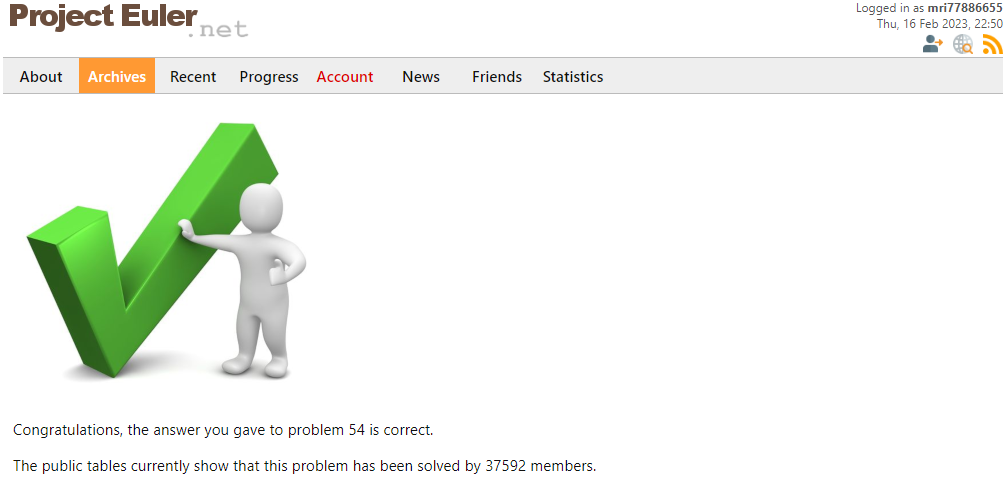

In [125]:
from IPython.display import Image
Image("Images/Solution_Confirmation_1.png")

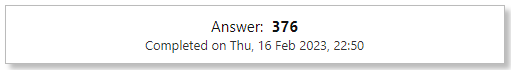

In [122]:
Image("Images/Solution_Confirmation_2.png")